Here the problem mentioned is a action recognition problem. Given an input image/ video we need to predict what action that user performing. For this task i followed below pipeline. \
(1) Take the input video and get the keypoint information.\
(2) Used a classifier that takes video as input gives corresponding class. \
\
Key points: \
Now to get keypoints from a video, i used mediapipe library. which have module name heuristic which gives key points for the input video frame wise. \
\
Classifier: \
Since we are taking video as input, we need to capture the temporal relation between frames to know the action. To achieve that part here i used spatial-temporal tranformer model which takes video as input and gives embedding for each frame. At the end of the transformer placed a neural network based classifier.\
\
Our transformer aimed ti capture spatial relations between keypoints within frame and temporal relations across frames.\
\
To train our transformer i used dataset named UCF 101- action recognition. This contains 101 classes.
Due to GPU and training time issues, i sampled only 15 classes out of it.\

Some hyper parameters: The Transfomer will take only 150 Frames (6 sec video with 25 FPS) of input video as input and gives corresponidng class label. I clipped the input frames to 150 if frames are greater than 150. Padded with zeros if it is less than 150.\
\
TO know about dataset follow below link: https://www.crcv.ucf.edu/data/UCF101.php\
\


#### Action Recognition

In [134]:
# !pip install mediapipe
import numpy as np
import pandas as pd
import random
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

In [36]:
# !pip install mediapipe

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim

In [136]:
from torch.utils.data import DataLoader,Dataset
import torch

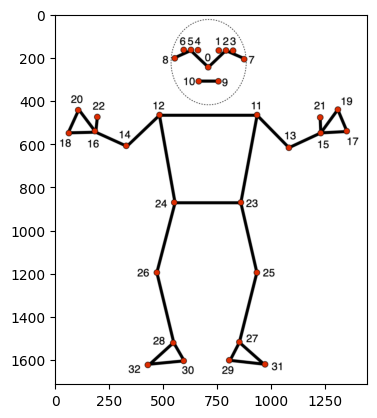

In [161]:
import matplotlib.pyplot as plt
img = plt.imread('/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/pose_landmarks_index.png')
plt.imshow(img)
plt.show()

##### Reading data

In [39]:
#loading csv files of 
train_csv = pd.read_csv(r"/Users/USER/Documents/Karthik_Fanplay_IoT/archive/train.csv")
val_csv = pd.read_csv(r"/Users/USER/Documents/Karthik_Fanplay_IoT/archive/val.csv")
test_csv = pd.read_csv(r"/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test.csv")

In [40]:
train_csv.head()

,clip_name,clip_path,label
0,v_Swing_g05_c02,/train/Swing/v_Swing_g05_c02.avi,Swing
1,v_Swing_g21_c03,/train/Swing/v_Swing_g21_c03.avi,Swing
2,v_Swing_g07_c01,/train/Swing/v_Swing_g07_c01.avi,Swing
3,v_Swing_g24_c04,/train/Swing/v_Swing_g24_c04.avi,Swing
4,v_Swing_g20_c03,/train/Swing/v_Swing_g20_c03.avi,Swing


In [41]:
train_csv['label'].unique() # list of classes

array(['Swing', 'SkyDiving', 'BreastStroke', 'TableTennisShot',
       'FloorGymnastics', 'Rowing', 'SoccerJuggling', 'BenchPress',
       'TennisSwing', 'FrisbeeCatch', 'Kayaking', 'ApplyLipstick',
       'RopeClimbing', 'JumpingJack', 'BlowingCandles', 'BabyCrawling',
       'HammerThrow', 'BoxingPunchingBag', 'Skiing', 'UnevenBars',
       'PullUps', 'RockClimbingIndoor', 'HeadMassage', 'HulaHoop',
       'Rafting', 'ShavingBeard', 'LongJump', 'FieldHockeyPenalty',
       'VolleyballSpiking', 'Punch', 'Archery', 'PlayingDhol',
       'CleanAndJerk', 'PlayingDaf', 'GolfSwing', 'PlayingSitar',
       'IceDancing', 'SkateBoarding', 'BodyWeightSquats',
       'HandstandPushups', 'BalanceBeam', 'WallPushups', 'HorseRiding',
       'Bowling', 'JumpRope', 'CuttingInKitchen', 'CliffDiving',
       'PlayingGuitar', 'FrontCrawl', 'HandstandWalking', 'Fencing',
       'Basketball', 'Typing', 'TaiChi', 'PlayingCello', 'Lunges',
       'Shotput', 'Nunchucks', 'ApplyEyeMakeup', 'BaseballPitch',
 

In [42]:
# 15 Classes
selected_classes = ['BoxingSpeedBag','SoccerJuggling','IceDancing','PlayingFlute',
 'Bowling','Fencing','TennisSwing','FloorGymnastics','JumpingJack','TableTennisShot','Basketball',
 'Archery','GolfSwing','BodyWeightSquats','Diving'
 ]
print(len(selected_classes))

15


In [144]:
print(f'number of train videos {len(train_csv)}')
print(f'number of test videos {len(test_csv)}')
print(f'number of val videos {len(val_csv)}')

number of train videos 10055

number of test videos 1723

number of val videos 1673


##### Key_points_extraction

In [146]:
def func1(keypoints):
    listi = []
    for i,keypoint in enumerate(keypoints):
        listi.append(np.array([keypoint.x,keypoint.y,keypoint.z,keypoint.visibility]))
    listi = np.array(listi).reshape(-1)
    return listi

In [147]:
# loading keypoints corresponding to video
# took code ref from internet

def keypoints(video_path):

    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils

    cap = cv2.VideoCapture(video_path)

    data = []
    with mp_pose.Pose() as pose:
        
        while cap.isOpened():
                ret, frame = cap.read()

                if not ret:
                    break
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)       
                
                # Make Detections
                results = pose.process(image)
                
                # Recolor image back to BGR for rendering  
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                   )
                    # print(results.pose_landmarks.landmark)
                    data.append(func1(results.pose_landmarks.landmark))


    cap.release()
    return data

In [148]:
#checking the working of above function
# data=keypoints(r'/home/karthik/ucf101-action-recognition'+test_csv['clip_path'][0])

In [149]:
selected_classes

['BoxingSpeedBag',
 'SoccerJuggling',
 'IceDancing',
 'PlayingFlute',
 'Bowling',
 'Fencing',
 'TennisSwing',
 'FloorGymnastics',
 'JumpingJack',
 'TableTennisShot',
 'Basketball',
 'Archery',
 'GolfSwing',
 'BodyWeightSquats',
 'Diving']

In [150]:
#reading train,test,val video paths class wise
def path_reading(csv_file, selected_classes, no_of_videos):
    c_random_samples = {}
    for c in selected_classes:
        c_data = csv_file[csv_file['label'] == c]
        c_data = c_data.drop(columns = 'label')
        c_random_samples[c] = c_data.sample(no_of_videos, random_state=42)  
    return c_random_samples


In [151]:
train_data = path_reading(train_csv, selected_classes, 75)
val_data = path_reading(val_csv, selected_classes, 10)
test_data = path_reading(test_csv, selected_classes, 10)

In [152]:
train_data.keys()

dict_keys(['BoxingSpeedBag', 'SoccerJuggling', 'IceDancing', 'PlayingFlute', 'Bowling', 'Fencing', 'TennisSwing', 'FloorGymnastics', 'JumpingJack', 'TableTennisShot', 'Basketball', 'Archery', 'GolfSwing', 'BodyWeightSquats', 'Diving'])

In [153]:
#appends keypoints of videos in a dictionary classwise
def read_keypoints(data,name_to_save):
    dict = {}
    for class_name in data.keys():
        print(class_name)
        if class_name not in dict.keys():
            dict[class_name] = []
        for path in data[class_name]['clip_path']:
                video_path = r'/Users/USER/Documents/Karthik_Fanplay_IoT/archive' + str(path)
                data_ = keypoints(video_path)
                if len(data_) != 0: #exclude that video if it doesn't have keypoint
                    dict[class_name].append(data_)


    return dict

In [154]:
train_dict = read_keypoints(train_data,'train_dict')

BoxingSpeedBag

SoccerJuggling

IceDancing

PlayingFlute

Bowling

Fencing

TennisSwing

FloorGymnastics

JumpingJack

TableTennisShot

Basketball

Archery

GolfSwing

BodyWeightSquats

Diving


In [155]:
val_dict = read_keypoints(val_data,'val_dict')

BoxingSpeedBag
SoccerJuggling

IceDancing

PlayingFlute

Bowling

Fencing

TennisSwing

FloorGymnastics

JumpingJack

TableTennisShot

Basketball

Archery

GolfSwing

BodyWeightSquats

Diving


In [156]:
test_dict = read_keypoints(test_data,'test_dict')

BoxingSpeedBag

SoccerJuggling

IceDancing

PlayingFlute

Bowling

Fencing

TennisSwing

FloorGymnastics

JumpingJack

TableTennisShot

Basketball

Archery

GolfSwing

BodyWeightSquats

Diving


In [157]:
# Assigns numbers to labels
labelling = {}
k = 0
print(len(selected_classes))
for i in selected_classes:
  labelling[i] = k
  k+=1
print((labelling))

15

{'BoxingSpeedBag': 0, 'SoccerJuggling': 1, 'IceDancing': 2, 'PlayingFlute': 3, 'Bowling': 4, 'Fencing': 5, 'TennisSwing': 6, 'FloorGymnastics': 7, 'JumpingJack': 8, 'TableTennisShot': 9, 'Basketball': 10, 'Archery': 11, 'GolfSwing': 12, 'BodyWeightSquats': 13, 'Diving': 14}


In [158]:
#assign features and labels video wise
def feat_lab_assign(dict_,labelling):
    # dict_ = pd.read_csv(csv)
    print(dict_.keys())
    features = []
    labels = []
    for (key,value) in dict_.items():
        for v in value:
            features.append(np.array(v))
            labels.append(labelling[key])
    labels = np.array(labels).reshape(-1)
    # features = np.array(features)
    
    return features,labels

In [159]:
#reads train_features and labels
train_feat_list,train_lab_list = feat_lab_assign(train_dict,labelling)
val_feat_list,val_lab_list = feat_lab_assign(val_dict,labelling)
test_feat_list,test_lab_list = feat_lab_assign(test_dict,labelling)

dict_keys(['BoxingSpeedBag', 'SoccerJuggling', 'IceDancing', 'PlayingFlute', 'Bowling', 'Fencing', 'TennisSwing', 'FloorGymnastics', 'JumpingJack', 'TableTennisShot', 'Basketball', 'Archery', 'GolfSwing', 'BodyWeightSquats', 'Diving'])

dict_keys(['BoxingSpeedBag', 'SoccerJuggling', 'IceDancing', 'PlayingFlute', 'Bowling', 'Fencing', 'TennisSwing', 'FloorGymnastics', 'JumpingJack', 'TableTennisShot', 'Basketball', 'Archery', 'GolfSwing', 'BodyWeightSquats', 'Diving'])

dict_keys(['BoxingSpeedBag', 'SoccerJuggling', 'IceDancing', 'PlayingFlute', 'Bowling', 'Fencing', 'TennisSwing', 'FloorGymnastics', 'JumpingJack', 'TableTennisShot', 'Basketball', 'Archery', 'GolfSwing', 'BodyWeightSquats', 'Diving'])


In [160]:
print(f'number of train videos {len(train_feat_list)}')
print(f'number of test videos {len(test_feat_list)}')
print(f'number of val videos {len(val_feat_list)}')

number of train videos 1072

number of test videos 144

number of val videos 141


In [ ]:
for i in train_feat_list:
    print(i.shape)
    break

(249, 132)


##### Data_Processing

In [162]:
class CustomDataset(Dataset):
    def __init__(self, data, trg, max_length=150):
        self.data = data
        self.trg = trg
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature = self.data[idx]
        label = self.trg[idx]

        # Convert to PyTorch tensors
        feature = torch.tensor(feature, dtype=torch.float)
        # print(feature.shape)
        label = torch.tensor(label, dtype=torch.long)

        # Calculate padding length
        pad_length = max(0, self.max_length - feature.shape[0])

        # Pad the sequence symmetrically
        left_pad = pad_length // 2
        right_pad = pad_length - left_pad
        padding = (0, 0, left_pad, right_pad)

        # Trim or pad the sequence to the desired length
        if feature.shape[0] != 0:
            if feature.shape[0] >= self.max_length:
                feature = feature[:self.max_length]
            elif feature.shape[0] < self.max_length:
                feature = torch.nn.functional.pad(feature, padding)

            return feature, label


In [163]:
Total_train_Data = CustomDataset(train_feat_list,train_lab_list)
Total_val_Data = CustomDataset(val_feat_list,val_lab_list)
Total_test_Data = CustomDataset(test_feat_list,test_lab_list)

In [164]:
for i,j in Total_train_Data:
    print(i.shape,j)
    break

torch.Size([150, 132]) tensor(0)


In [165]:
train_loader = DataLoader(Total_train_Data,batch_size=32,shuffle = True)
val_loader = DataLoader(Total_val_Data,batch_size=32,shuffle = True)
test_loader = DataLoader(Total_test_Data,batch_size=32,shuffle = False)

In [166]:
for i,j in train_loader:
    print(i.shape,j.shape)
    break

torch.Size([32, 150, 132]) torch.Size([32])


##### Model_Building

The below diagram shows what my model will do.

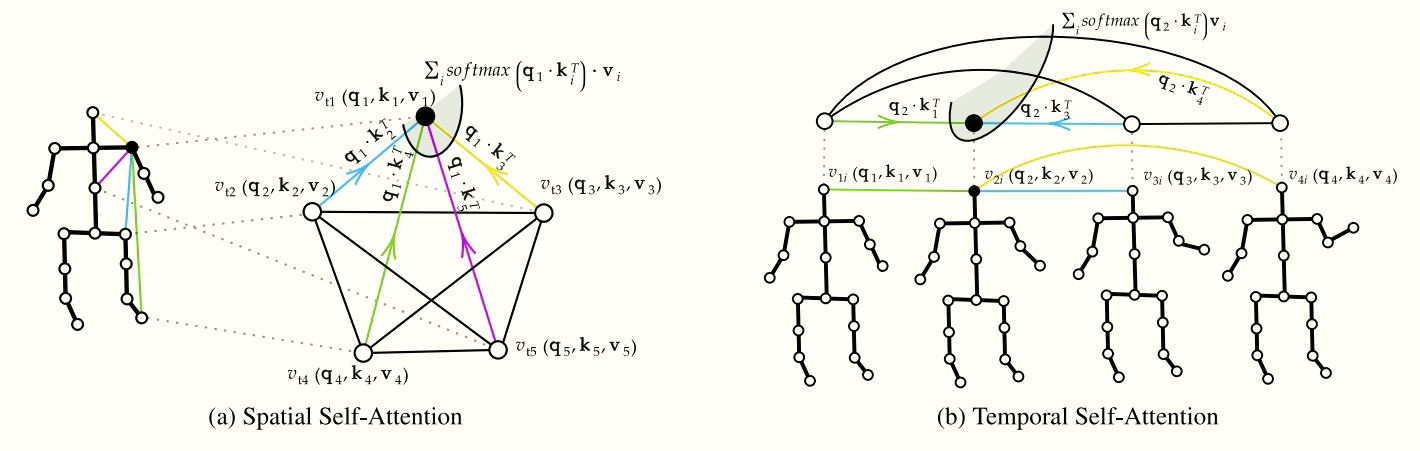

In [ ]:

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

#gives positional embedings frame wise
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=150):
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.d_model = d_model
        self.pe = self.generate_positional_encoding()

    def generate_positional_encoding(self):
        pe = torch.zeros(self.max_len, self.d_model)
        pos = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        return pe

    def forward(self, x):
        # Add positional encoding to input tensor x
        seq_len = x.size(0)
        # print(self.pe.shape)
        # pe_slice = self.pe[:seq_len, :]
        pe_slice = self.pe.to(device)
        # print(pe_slice.shape,x.shape)
        return x + pe_slice

In [ ]:
#calculates correlation between key points with in frame
class Spatial_Transformer(nn.Module):
    def __init__(self,d_keypoint,num_heads,num_layers,dropout=0.2):
        super(Spatial_Transformer,self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_keypoint, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.positional_encoding= PositionalEncoding(d_model = d_keypoint, max_len = 33)
        self.fc0 = nn.Linear(4,d_keypoint)
        self.fc1 = nn.Linear(d_keypoint,4)
    def forward(self,keypoint_in_frame):
        keypoint_in_frame = keypoint_in_frame.view(-1,33,4)
        keypoint_in_frame = self.fc0(keypoint_in_frame)
        # print(keypoint_in_frame.shape)
        keypoint_in_frame = self.positional_encoding(keypoint_in_frame)
        keypoint_in_frame = self.transformer_encoder(keypoint_in_frame)
        keypoint_in_frame = self.fc1(keypoint_in_frame)
        keypoint_in_frame = keypoint_in_frame.view(-1,150,132)
        return keypoint_in_frame

In [ ]:
#calculates correlation between keypoint across frames
class Temporal_Transformer(nn.Module):
    def __init__(self, no_key_points, d_model, num_heads, num_layers, no_classes, dropout=0.2):
        super(Temporal_Transformer, self).__init__()
        #gives positional encoding keypoint wise within frame 
        # self.embedding = nn.Embedding(no_key_points, 4) 
        #gives positional embedding for frames
        self.positional_encoding = PositionalEncoding(d_model) 
        #initilizing temporal transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        #initilizing spatial transformer
        self.Spatial_Transformer = Spatial_Transformer(d_keypoint=8,num_heads=2,num_layers=2).to(device)
        #MLP for classification
        self.fc1 = nn.Sequential(nn.Linear(132,1),
                                 nn.BatchNorm1d(150),
                                 nn.Tanh())
        self.fc2=   nn.Sequential(
                                 nn.Linear(150,no_classes),
                                 nn.Softmax(dim=1))
        
    

    def forward(self, frame_wise_keypoints):
        #emb gives positional embedding to each node
        # emb = torch.tensor([i for i in range(33)],dtype=torch.long).to(device) 
     
        # emb= self.embedding(emb)
     
        # print(emb.shape)
        # emb = emb.view(-1)
        # frame_wise_keypoints += emb
        frame_wise_keypoints = self.Spatial_Transformer(frame_wise_keypoints)
        frame_wise_keypoints = self.positional_encoding(frame_wise_keypoints)
        # print(frame_wise_keypoints.shape)
        
        output = self.transformer_encoder(frame_wise_keypoints)
        # print(output.shape)
        output = self.fc1(output).squeeze()
        # print(output.shape)
        output = self.fc2(output)
        return output

In [ ]:
model = Temporal_Transformer(no_key_points = 33, d_model = 132, num_heads = 4, num_layers = 3, no_classes = len(selected_classes))
model.to(device) 

Temporal_Transformer(
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=132, out_features=132, bias=True)
        )
        (linear1): Linear(in_features=132, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=132, bias=True)
        (norm1): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (Spatial_Transformer): Spatial_Transformer(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
     

In [ ]:
model(torch.rand((2,150,132)).to(device)).shape

torch.Size([2, 15])

In [ ]:
parameters = sum(param.numel() for param in model.parameters() if param.requires_grad)
print(f'number of parameters {parameters}')

number of parameters 1913874


In [ ]:
model

Temporal_Transformer(
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=132, out_features=132, bias=True)
        )
        (linear1): Linear(in_features=132, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=132, bias=True)
        (norm1): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((132,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (Spatial_Transformer): Spatial_Transformer(
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
     

In [ ]:
# model.load_state_dict(torch.load('best_model.pth'))

##### Model Training 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay= 0.01)

In [ ]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# del model
# del inputs
# del labels

In [ ]:

# Training loop
num_epochs = 500
best_loss = 1e5
for epoch in range(num_epochs):
    model.train()  
    train_loss = 0.0


    for inputs, labels in train_loader:
       
        inputs, labels = inputs.to(device), labels.to(device)
        # print(inputs.device.type, labels.device.type)
      
        optimizer.zero_grad()

     
        outputs = model(inputs)
  
      
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
            
       
        train_loss += loss.item() * inputs.size(0)

   
    epoch_loss = train_loss / len(Total_train_Data)
    print('--------------Training Loss---------------')
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

   
    model.eval()
    val_loss = 0.0

    for inputs, labels in val_loader:
 
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)

    epoch_loss = val_loss / len(Total_val_Data)
    if epoch_loss <= best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), '/Users/USER/Documents/Karthik_Fanplay_IoT/archive/best__model_1.pth')
    print('--------------Validation Loss---------------')
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")




--------------Training Loss---------------

Epoch [1/2000], Loss: 2.7043

--------------Validation Loss---------------

Epoch [1/2000], Loss: 2.6983

--------------Training Loss---------------

Epoch [2/2000], Loss: 2.6906

--------------Validation Loss---------------

Epoch [2/2000], Loss: 2.6697

--------------Training Loss---------------

Epoch [3/2000], Loss: 2.6625

--------------Validation Loss---------------

Epoch [3/2000], Loss: 2.6456

--------------Training Loss---------------

Epoch [4/2000], Loss: 2.6356

--------------Validation Loss---------------

Epoch [4/2000], Loss: 2.6237

--------------Training Loss---------------

Epoch [5/2000], Loss: 2.6189

--------------Validation Loss---------------

Epoch [5/2000], Loss: 2.6079

--------------Training Loss---------------

Epoch [6/2000], Loss: 2.6018

--------------Validation Loss---------------

Epoch [6/2000], Loss: 2.6035

--------------Training Loss---------------

Epoch [7/2000], Loss: 2.5886

--------------Validation L

KeyboardInterrupt: 

##### Evaluating Model

In [168]:
# Loading best model
model.load_state_dict(torch.load('/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
predicted_labels =  []
ground_truth_labels =  []
# Evaluating the model
model.eval() 
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.append(predicted.cpu().detach().numpy())
        ground_truth_labels.append(labels.cpu().detach().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 75.69%


In [169]:
ground_truth_labels = [i for j in ground_truth_labels for i in j]
predicted_labels = [k for l in predicted_labels for k in l]

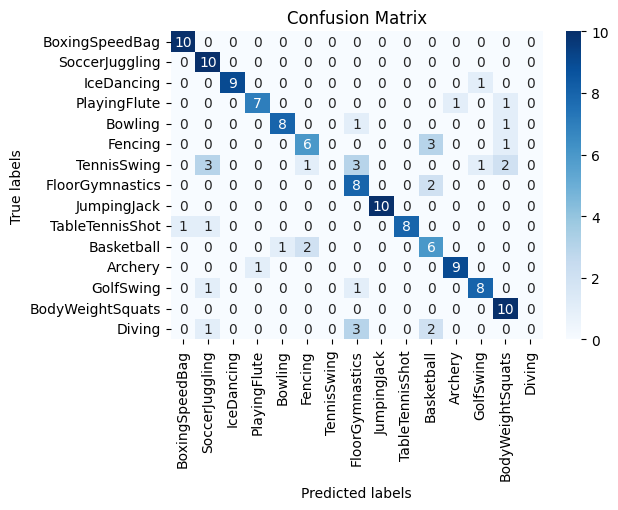

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(ground_truth_labels, predicted_labels)

# Plotting the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# #heatmap between spatial transformer for right predictions
# outputs = model.Spatial_Transformer(keypoints)

In [76]:
# matrix = F.cosine_similarity(outputs[1][55].view(-1,4).unsqueeze(1),outputs[1][55].view(-1,4).unsqueeze(0),dim=2).cpu().detach().numpy()

In [62]:
# nodes = [i for i in range(33)]

In [ ]:
# # Plotting the heatmap
# import seaborn as sns
# plt.figure(figsize=(8, 6))
# sns.heatmap(matrix, annot=False, cmap='viridis', xticklabels=nodes, yticklabels=nodes)
# plt.xlabel('Nodes')
# plt.ylabel('Nodes')
# plt.title('Attention map')
# plt.show()

##### Model_running

In [123]:
selected_classes = ['BoxingSpeedBag','SoccerJuggling','IceDancing','PlayingFlute',
 'Bowling','Fencing','TennisSwing','FloorGymnastics','JumpingJack','TableTennisShot','Basketball',
 'Archery','GolfSwing','BodyWeightSquats','Diving'
 ]

In [124]:
# Assigns numbers to labels
labelling = {}
k = 0
print(len(selected_classes))
for i in selected_classes:
  labelling[i] = k
  k+=1
print((labelling))

15

{'BoxingSpeedBag': 0, 'SoccerJuggling': 1, 'IceDancing': 2, 'PlayingFlute': 3, 'Bowling': 4, 'Fencing': 5, 'TennisSwing': 6, 'FloorGymnastics': 7, 'JumpingJack': 8, 'TableTennisShot': 9, 'Basketball': 10, 'Archery': 11, 'GolfSwing': 12, 'BodyWeightSquats': 13, 'Diving': 14}


In [125]:
def func1(keypoints):
    listi = []
    for i,keypoint in enumerate(keypoints):
        listi.append(np.array([keypoint.x,keypoint.y,keypoint.z,keypoint.visibility]))
    listi = np.array(listi).reshape(-1)
    return listi

In [126]:
def keypoints_processing(keypoints):
    keypoints = torch.tensor(keypoints, dtype=torch.float)

        # Calculate padding length
    pad_len = max(0, 150 - keypoints.shape[0])

        # Pad the sequence symmetrically
    left_pad = pad_len // 2
    right_pad = pad_len - left_pad
    padding = (0, 0, left_pad, right_pad)

        # Trim or pad the sequence to the desired length
    if keypoints.shape[0] > 150:
        keypoints = keypoints[:150]
    elif keypoints.shape[0] < 150:
        keypoints = torch.nn.functional.pad(keypoints, padding)
    else:
        pass
    keypoints = torch.stack((torch.zeros_like(keypoints),keypoints)) #to eliminate shape mismatches while processing
    return keypoints

In [172]:
def Evaluating(vid_path,mod_path,path,i):
    pose_ = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    data_ = []
    storing = {}
    storing['input_vid'] = storing['keypoint_vid'] = []
    #displays input video
    # Define the codec and create VideoWriter object
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for the video format (e.g., XVID, MJPG, DIVX)
    # input_video = cv2.VideoWriter(str(path)+'input.avi', fourcc, 25.0, (320, 240))  # Output filename, codec, fps, frame size

    cap = cv2.VideoCapture(vid_path)
    while cap.isOpened():
        ret, frame = cap.read()
        storing['input_vid'].append(frame)
        if not ret:
            print("End of video.")
            break
        # input_video.write(frame)
        cv2.imshow('Original', frame)
        if cv2.waitKey(2) & 0xFF == ord('q'):
            break
    cap.release()
    # input_video.release()
    cv2.destroyAllWindows()

    #displays video with keypoints
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for the video format (e.g., XVID, MJPG, DIVX)
    keypoint_video = cv2.VideoWriter(path+f'/keypoints/keypoint{i}.avi', fourcc, 30.0, (320, 240))  # Output filename, codec, fps, frame size
    cap = cv2.VideoCapture(vid_path) #For keypoints detection
    with pose_.Pose() as pose:
        
        while cap.isOpened():
                ret, frame = cap.read()

                if not ret:
                    break
                # Recolor Feed
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # image.flags.writeable = False        
                
                # Make Detections
                results = pose.process(image)
                # print(results.face_landmarks)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                
                if results.pose_landmarks:
                    mp_drawing.draw_landmarks(image, results.pose_landmarks, pose_.POSE_CONNECTIONS, 
                                        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                        )
                    
                    data_.append(func1(results.pose_landmarks.landmark))

                # Write the frame with landmarks to the output video
                # out.write(image)
                keypoint_video.write(image)
                cv2.imshow('MediaPipe Pose', image)
                storing['keypoint_vid'].append(image)
                # Press 'q' to exit
                if cv2.waitKey(5) & 0xFF == ord('q'):
                    break

    cap.release()
    # out.release()
    keypoint_video.release()
    cv2.destroyAllWindows()

    #Model prediction
    if len(data_)!=0:
        keypoints = keypoints_processing(data_) #converting into model required form

        model.load_state_dict(torch.load(mod_path)) #loading model from path

        # model = model.to(device)        
        keypoints = keypoints.to(device)

        pred = model(keypoints) #forward pass

        _, label = torch.max(pred, 1) #predicting label

        label = label.cpu().detach().numpy() 
        # print(label)
        #to know label name
        for k,v in labelling.items():
            if v == label[-1]: 
                text = k
                print(f'Action Performed by the person: {k}')



        #labelling keypoint extracted video            
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')  # Codec for the video format (e.g., XVID, MJPG, DIVX)
        output_video = cv2.VideoWriter(path+f'/outputs/ouput{i}.avi', fourcc, 30.0, (320, 240))  # Output filename, codec, fps, frame size
        cap = cv2.VideoCapture(vid_path) #loading keypoint video
        with pose_.Pose() as pose:
            while cap.isOpened():
                ret, frame = cap.read()

                if not ret:
                    break
                    # # Recolor Feed
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    # # image.flags.writeable = False        
                    
                # Make Detections
                results = pose.process(image)
                    # # print(results.face_landmarks)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    
                mp_drawing.draw_landmarks(image, results.pose_landmarks, pose_.POSE_CONNECTIONS, 
                                            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                            )

                #adding label to text
                cv2.putText(image, text, (25, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


                    # Write the frame with landmarks to the output video
                    # out.write(image)
                output_video.write(image)
                cv2.imshow('output', image)

                    # Press 'q' to exit
                if cv2.waitKey(5) & 0xFF == ord('q'):
                    break

        cap.release()
        output_video.release()
        cv2.destroyAllWindows()
        return storing,keypoints
    else:
        print('Keypoints not detected, please try with different video')

In [115]:
#test video 1
vid_path ='/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/BoxingSpeedBag/v_BoxingSpeedBag_g07_c07.avi'
mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
path_to_save ='/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/'
storing,keypoints = Evaluating(vid_path,mod_path,path_to_save,1)

End of video.

Action Performed by the person: BoxingSpeedBag


In [116]:
#test video 2
vid_path ='/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/Archery/v_Archery_g02_c01.avi'
mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
path_to_save ='/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/'
storing,keypoints = Evaluating(vid_path,mod_path,path_to_save,2)

End of video.

Action Performed by the person: PlayingFlute


In [117]:
#test video 3
vid_path ='/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/PlayingFlute/v_PlayingFlute_g12_c02.avi'
mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
path_to_save ='/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/'
storing,keypoints = Evaluating(vid_path,mod_path,path_to_save,3)

End of video.

Action Performed by the person: PlayingFlute


###### experiments

In [ ]:
import os
import random

In [132]:

#some videos from train dataset
j=0
mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
path_to_save = '/Users/USER/Documents/Karthik_Fanplay_IoT/videos_from_train_dataset/'


for i in selected_classes:
    paths = os.listdir("/Users/USER/Documents/Karthik_Fanplay_IoT/archive/train/"+i)
    path = random.sample(paths,1)
    vid_path = "/Users/USER/Documents/Karthik_Fanplay_IoT/archive/train/"+i +"/"+path[0]
    _,_ = Evaluating(vid_path,mod_path,path_to_save,j) 
    j+=1

End of video.

Action Performed by the person: BoxingSpeedBag

End of video.

Action Performed by the person: SoccerJuggling

End of video.

Action Performed by the person: IceDancing

End of video.

Action Performed by the person: PlayingFlute

End of video.

Action Performed by the person: Fencing

End of video.

Action Performed by the person: Fencing

End of video.

Action Performed by the person: BodyWeightSquats

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: JumpingJack

End of video.

Action Performed by the person: TableTennisShot

End of video.

Action Performed by the person: Fencing

End of video.

Action Performed by the person: BodyWeightSquats

End of video.

Action Performed by the person: GolfSwing

End of video.

Action Performed by the person: BodyWeightSquats

End of video.

Keypoints not detected, please try with different video


TypeError: cannot unpack non-iterable NoneType object

In [170]:


#some videos from test dataset
j=0
mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
path_to_save = '/Users/USER/Documents/Karthik_Fanplay_IoT/videos_from_test_dataset/'


for i in selected_classes:
    paths = os.listdir("/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/"+i)
    path = random.sample(paths,1)
    vid_path = "/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/"+i +"/"+path[0]
    _,_ = Evaluating(vid_path,mod_path,path_to_save,j) 
    j+=1

End of video.

Action Performed by the person: BoxingSpeedBag

End of video.

Action Performed by the person: SoccerJuggling

End of video.

Action Performed by the person: IceDancing

End of video.

Action Performed by the person: PlayingFlute

End of video.

Action Performed by the person: Basketball

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: Basketball

End of video.

Action Performed by the person: JumpingJack

End of video.

Action Performed by the person: TableTennisShot

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: Archery

End of video.

Action Performed by the person: GolfSwing

End of video.

Action Performed by the person: BodyWeightSquats

End of video.

Action Performed by the person: Basketball


In [173]:
#Some videos from internet
paths = os.listdir("/Users/USER/Documents/Karthik_Fanplay_IoT/dataset/dataset")

j= 0
for i in paths:
    vid_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/dataset/dataset/'+i
    mod_path = '/Users/USER/Documents/Karthik_Fanplay_IoT/Problem1/best__model_1.pth'
    path_to_save = '/Users/USER/Documents/Karthik_Fanplay_IoT/videos_from_internet/'

    _,_ = Evaluating(vid_path,mod_path,path_to_save,j)
    j+=1
    

End of video.

Action Performed by the person: BoxingSpeedBag

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: IceDancing

End of video.

Action Performed by the person: FloorGymnastics

End of video.

Action Performed by the person: GolfSwing

End of video.

Action Performed by the person: BodyWeightSquats

End of video.

Action Performed by the person: PlayingFlute

End of video.

Action Performed by the person: SoccerJuggling

End of video.

Action Performed by the person: Archery

End of video.

Action Performed by the person: BodyWeightSquats


In [179]:
#labelling keypoint extracted video            
# fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for the video format (e.g., XVID, MJPG, DIVX)
# output_video = cv2.VideoWriter(path+f'/outputs/ouput{i}.avi', fourcc, 30.0, (320, 240))  # Output filename, codec, fps, frame size
def keypoints_checking(vid_path):
    pose_ = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    cap = cv2.VideoCapture(vid_path) #loading keypoint video
    i = 0
    with pose_.Pose() as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break
                        # # Recolor Feed
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        # # image.flags.writeable = False        
                        
                    # Make Detections
            results = pose.process(image)
                        # # print(results.face_landmarks)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            frame= np.ones_like(image)*255        
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, pose_.POSE_CONNECTIONS, 
                                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                                )

                    #adding label to text
            # cv2.putText(image, text, (25, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    # output_video.write(image)
            cv2.imshow('output', frame)

                        # Press 'q' to exit
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break
    cap.release()
    # output_video.release()
    cv2.destroyAllWindows()

In [178]:
keypoints_checking('/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/Archery/v_Archery_g02_c01.avi')
keypoints_checking('/Users/USER/Documents/Karthik_Fanplay_IoT/archive/test/PlayingFlute/v_PlayingFlute_g12_c02.avi')